In [1]:
import numpy as np

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

from datetime import datetime as dt

import sys

# Adicione o caminho do subdiretório ao caminho de busca do Python
sys.path.append('modelos')

import xgb
import nn

## Recebendo os dados e Preparando eles para a classificação
Eu recebo o dataset da Premier-League faço o pré-processamento dele, a gente vai dividir o treino em temporadas de 2000 até 2018, onde o teste vai ser 2019 até 2021

Além disso, como vamos testar para classificação multiclasse e binária nós eu faço o tratamento do target para os dois casos. Vale lembrar também que graças a características das nossas features que levam em consideração dados de 3 jogos atrás, resolvemos excluir os 3 primeiros jogos de cada time, dessa forma, todas as tuplas terão informações de 3 jogos que realmente já aconteceram.

In [2]:
# Lendo a base de dados

loc = "./Premier-League/"
dataset = pd.read_csv(loc + "premier_league2001-2021.csv")

In [3]:
# Tirando as primeiras 3 semanas rodadas de cada ano

datasetParsed = dataset.drop(dataset.loc[(dataset["MW"] == 1)  | (dataset["MW"] == 2) | (dataset["MW"] == 3)].index)
datasetParsed

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,...,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffFormPts3,DiffLP
30,2000-09-05,Man United,Bradford,6,0,H,5,2,3,1,...,0,0,0,0,0.500000,0.250000,0.250000,1,1,-16.0
31,2000-09-05,Sunderland,West Ham,1,1,D,3,4,5,7,...,0,0,0,0,-0.500000,-0.750000,0.500000,2,2,-2.0
32,2000-09-05,Tottenham,Everton,3,2,H,4,5,4,4,...,0,0,0,0,0.000000,0.250000,0.000000,0,0,-3.0
33,2000-09-06,Charlton,Southampton,1,1,D,7,6,8,7,...,0,0,0,0,-0.250000,-0.250000,0.250000,1,1,3.0
34,2000-09-06,Chelsea,Arsenal,2,2,D,5,7,5,4,...,0,0,0,0,0.000000,0.750000,-0.500000,-2,-2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7975,2021-05-23,Liverpool,Crystal Palace,2,0,H,66,41,42,64,...,0,0,0,0,0.631579,-0.605263,0.578947,7,6,-13.0
7976,2021-05-23,Man City,Everton,5,0,H,78,47,32,43,...,0,0,0,0,1.210526,0.105263,0.631579,2,-1,-10.0
7977,2021-05-23,Sheffield United,Burnley,1,0,H,19,33,63,54,...,0,0,0,0,-1.157895,-0.552632,-0.500000,0,0,-1.0
7978,2021-05-23,West Ham,Southampton,3,0,H,59,47,47,65,...,0,0,0,0,0.315789,-0.473684,0.500000,0,-2,5.0


In [4]:
selectedColumns = ["Date","DiffLP", "DiffPts", "DiffFormPts3",  # Diferenças
                    "HTWinStreak3", "ATWinStreak3","HTLossStreak3", "ATLossStreak3", # Streaks
                    "HTGS", "ATGS", "HTGC", "ATGC", # Gols Feitos e Recebidos de cada um
                    "HTFormPts3", "ATFormPts3", # Pontos ganhos nas últimas semanas
                    "HTGD", "ATGD", "HomeTeamLP", "AwayTeamLP", # Diferença de Gol
                    "HM1","HM2","HM3","AM1","AM2","AM3", # Resultado dos últimos 3 jogos
                    "HSA", "ASA", "HSTA", "ASTA", "FTR"] # Chutes e Chutes a Gol


datasetSelected = datasetParsed[selectedColumns]

In [5]:
columns_to_encode = ["HM1", "HM2", "HM3", "AM1", "AM2", "AM3"] 
# Para fazer o OneHotEncoding das variáveis HM e AM

# Realiza o one-hot encoding nas colunas selecionadas
datasetSelected_encoded = pd.get_dummies(datasetSelected, columns=columns_to_encode)

datasetSelected_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7350 entries, 30 to 7979
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7350 non-null   object 
 1   DiffLP         7350 non-null   float64
 2   DiffPts        7350 non-null   float64
 3   DiffFormPts3   7350 non-null   int64  
 4   HTWinStreak3   7350 non-null   int64  
 5   ATWinStreak3   7350 non-null   int64  
 6   HTLossStreak3  7350 non-null   int64  
 7   ATLossStreak3  7350 non-null   int64  
 8   HTGS           7350 non-null   int64  
 9   ATGS           7350 non-null   int64  
 10  HTGC           7350 non-null   int64  
 11  ATGC           7350 non-null   int64  
 12  HTFormPts3     7350 non-null   int64  
 13  ATFormPts3     7350 non-null   int64  
 14  HTGD           7350 non-null   float64
 15  ATGD           7350 non-null   float64
 16  HomeTeamLP     7350 non-null   float64
 17  AwayTeamLP     7350 non-null   float64
 18  HSA         

In [6]:
# Separando em treino e teste pelo tempo e dando um shuffle em tudo

train = datasetSelected_encoded.loc[
                datasetSelected_encoded["Date"] < "2015-08-11"].sample(frac = 1, random_state = 42)

test = datasetSelected_encoded.loc[
                datasetSelected_encoded["Date"] >= "2015-08-11"].sample(frac = 1, random_state = 42)

print(train.shape)
print(test.shape)


(5250, 41)
(2100, 41)


In [7]:
y_train = np.array(train["FTR"]).reshape(-1, 1)
y_test = np.array(test["FTR"]).reshape(-1, 1)

x_train = pd.DataFrame(np.array(train.drop(["FTR", "Date"], axis = 1)))
x_test = np.array(test.drop(["FTR", "Date"], axis = 1))

# Separando em x e y

In [8]:
# Normalização dos dados em MinMax e transformando o y_ em OneHot para classifcação multiclasse

scaler = MinMaxScaler()
x_train_encoded = scaler.fit_transform(x_train)
x_test_encoded = scaler.transform(x_test)

encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train).toarray()
y_test_encoded = encoder.transform(y_test).toarray()

input_size = x_train_encoded.shape[1]
output_size = y_train_encoded.shape[1]

In [9]:
# preparando os dados para a classificação binária

functionHNH = np.vectorize(lambda x: "H" if x=="H" else "NH")

y_train_ = functionHNH(y_train)
y_test_ = functionHNH(y_test)

y_train_ = np.where(y_train_ == "H", 1, 0)
y_test_ = np.where(y_test_ == "H", 1, 0)

## Treinamento dos Modelos

Para Multiclasse vamos treinar uma rede neural simples, com 5 camadas, e para a classificação binária será feita um número maior de modelos.

Nós dois casos foi feito GridSearch Cross-Validation separadamente com os dados de treino e, após a seleção dos melhores parâmetros foi feito o treino verdadeiramente e é feito o teste com os dados de teste.

In [10]:
# best_parameters_nn = nn.trainValidation(x_train_encoded, y_train_encoded, 125) 
# Coloquei 125 pra não demorar muito, computador demora muito pra rodar isso

#Já rodei e o resultado foi:

# best_parameters_nn = {'learning_rate': 0.1, 'momentum': 0.7, 'weight_decay': 0.0005}

In [11]:
print("Finalizou.")

best_parameters_nn = {'learning_rate': 0.1, 'momentum': 0.7, 'weight_decay': 0.0005}

Finalizou.


In [12]:
best_parameters_xgb = xgb.trainValidation(x_train_encoded, y_train_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=15, min_child_weight=10, n_estimators=80, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=15, min_child_weight=10, n_estimators=80, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=15, min_child_weight=10, n_estimators=80, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=15, min_child_weight=10, n_estimators=80, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=15, min_child_weight=10, n_estimators=80, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=15, min_c

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=15, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=15, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=15, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=15, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=15, min_child_weight=3, n_estimators=40, reg_alpha=1e-05, scale_pos_weight=1, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=15, min_

In [13]:
print("Finalizou.")

# melhores parametros do grid:
# {'colsample_bytree': 0.8, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 20, 
# 'n_estimators': 40, 'reg_alpha': 1e-05, 'scale_pos_weight': 1, 'subsample': 0.8}
best_parameters_xgb

Finalizou.


{'colsample_bytree': 0.8,
 'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 20,
 'n_estimators': 40,
 'reg_alpha': 1e-05,
 'scale_pos_weight': 1,
 'subsample': 0.8}

x_train shape: torch.Size([5250, 39])
y_train shape: torch.Size([5250, 3])
x_test shape: torch.Size([2100, 39])
y_test shape: torch.Size([2100, 3])
Epoch 0 Train: Cross-entropy=1.0596215950279702, Accuracy=0.4603658536585366
Epoch 0 Test: Cross-entropy=1.0364986658096313, Accuracy=0.4642857015132904
Epoch 1 Train: Cross-entropy=1.0086252013357675, Accuracy=0.5219131097560976
Epoch 1 Test: Cross-entropy=1.0126471519470215, Accuracy=0.5204761624336243
Epoch 2 Train: Cross-entropy=0.9982237692286329, Accuracy=0.5295350609756098
Epoch 2 Test: Cross-entropy=1.0058757066726685, Accuracy=0.526190459728241
Epoch 3 Train: Cross-entropy=0.9951266202984786, Accuracy=0.5327743902439024
Epoch 3 Test: Cross-entropy=1.005665898323059, Accuracy=0.523809552192688
Epoch 4 Train: Cross-entropy=0.9940924113843499, Accuracy=0.5375381097560976
Epoch 4 Test: Cross-entropy=1.0051541328430176, Accuracy=0.5233333110809326
Epoch 5 Train: Cross-entropy=0.9926115834131474, Accuracy=0.5386814024390244
Epoch 5 Test:

Epoch 53 Train: Cross-entropy=0.98337604650637, Accuracy=0.5461128048780488
Epoch 53 Test: Cross-entropy=1.003588080406189, Accuracy=0.5195237994194031
Epoch 54 Train: Cross-entropy=0.9830917119979858, Accuracy=0.5453506097560976
Epoch 54 Test: Cross-entropy=1.0018575191497803, Accuracy=0.523809552192688
Epoch 55 Train: Cross-entropy=0.9825330325743047, Accuracy=0.5453506097560976
Epoch 55 Test: Cross-entropy=1.002760887145996, Accuracy=0.522857129573822
Epoch 56 Train: Cross-entropy=0.9823143969221813, Accuracy=0.5483993902439024
Epoch 56 Test: Cross-entropy=1.0026253461837769, Accuracy=0.5209524035453796
Epoch 57 Train: Cross-entropy=0.9826400236385625, Accuracy=0.546875
Epoch 57 Test: Cross-entropy=1.0029081106185913, Accuracy=0.5195237994194031
Epoch 58 Train: Cross-entropy=0.9822577717827587, Accuracy=0.5463033536585366
Epoch 58 Test: Cross-entropy=1.0050231218338013, Accuracy=0.5204761624336243
Epoch 59 Train: Cross-entropy=0.9822492977467979, Accuracy=0.5464939024390244
Epoch 59

Epoch 107 Train: Cross-entropy=0.9825177243570002, Accuracy=0.5491615853658537
Epoch 107 Test: Cross-entropy=1.0028414726257324, Accuracy=0.5176190733909607
Epoch 108 Train: Cross-entropy=0.9828241918145156, Accuracy=0.5464939024390244
Epoch 108 Test: Cross-entropy=1.0018540620803833, Accuracy=0.5219047665596008
Epoch 109 Train: Cross-entropy=0.9822873196950773, Accuracy=0.5472560975609756
Epoch 109 Test: Cross-entropy=1.0019952058792114, Accuracy=0.522857129573822
Epoch 110 Train: Cross-entropy=0.9823631280806007, Accuracy=0.549733231707317
Epoch 110 Test: Cross-entropy=1.0034407377243042, Accuracy=0.5195237994194031
Epoch 111 Train: Cross-entropy=0.9827842857779526, Accuracy=0.5472560975609756
Epoch 111 Test: Cross-entropy=1.0024971961975098, Accuracy=0.5204761624336243
Epoch 112 Train: Cross-entropy=0.9818289941403924, Accuracy=0.5464939024390244
Epoch 112 Test: Cross-entropy=1.0015729665756226, Accuracy=0.5233333110809326
Epoch 113 Train: Cross-entropy=0.9826091753273476, Accuracy=

Epoch 160 Train: Cross-entropy=0.9827650254819451, Accuracy=0.5480182926829268
Epoch 160 Test: Cross-entropy=1.0019042491912842, Accuracy=0.5219047665596008
Epoch 161 Train: Cross-entropy=0.9830467373859592, Accuracy=0.5504954268292683
Epoch 161 Test: Cross-entropy=1.003438949584961, Accuracy=0.5195237994194031
Epoch 162 Train: Cross-entropy=0.9826396289395123, Accuracy=0.5436356707317073
Epoch 162 Test: Cross-entropy=1.0026265382766724, Accuracy=0.5209524035453796
Epoch 163 Train: Cross-entropy=0.9825779410397134, Accuracy=0.5472560975609756
Epoch 163 Test: Cross-entropy=1.0010210275650024, Accuracy=0.522857129573822
Epoch 164 Train: Cross-entropy=0.9818326758175362, Accuracy=0.5510670731707317
Epoch 164 Test: Cross-entropy=1.001307725906372, Accuracy=0.5195237994194031
Epoch 165 Train: Cross-entropy=0.9822935222125635, Accuracy=0.545922256097561
Epoch 165 Test: Cross-entropy=1.003352403640747, Accuracy=0.5185714364051819
Epoch 166 Train: Cross-entropy=0.9826871207574519, Accuracy=0.5

Epoch 213 Train: Cross-entropy=0.9824776518635634, Accuracy=0.5455411585365854
Epoch 213 Test: Cross-entropy=1.0026473999023438, Accuracy=0.5223809480667114
Epoch 214 Train: Cross-entropy=0.9822994354294567, Accuracy=0.545922256097561
Epoch 214 Test: Cross-entropy=1.0032124519348145, Accuracy=0.5204761624336243
Epoch 215 Train: Cross-entropy=0.9830691182031864, Accuracy=0.5457317073170732
Epoch 215 Test: Cross-entropy=1.0025848150253296, Accuracy=0.5223809480667114
Epoch 216 Train: Cross-entropy=0.9828554166526329, Accuracy=0.5472560975609756
Epoch 216 Test: Cross-entropy=1.0035864114761353, Accuracy=0.5204761624336243
Epoch 217 Train: Cross-entropy=0.9818494857811346, Accuracy=0.5457317073170732
Epoch 217 Test: Cross-entropy=1.0016366243362427, Accuracy=0.5214285850524902
Epoch 218 Train: Cross-entropy=0.982734442484088, Accuracy=0.5485899390243902
Epoch 218 Test: Cross-entropy=1.0030180215835571, Accuracy=0.5204761624336243
Epoch 219 Train: Cross-entropy=0.9822614810815672, Accuracy=

Epoch 266 Train: Cross-entropy=0.9815373733276274, Accuracy=0.5495426829268293
Epoch 266 Test: Cross-entropy=1.0011348724365234, Accuracy=0.5209524035453796
Epoch 267 Train: Cross-entropy=0.9819363370174314, Accuracy=0.547827743902439
Epoch 267 Test: Cross-entropy=1.0017858743667603, Accuracy=0.522857129573822
Epoch 268 Train: Cross-entropy=0.9830282643073942, Accuracy=0.5470655487804879
Epoch 268 Test: Cross-entropy=1.0030806064605713, Accuracy=0.5219047665596008
Epoch 269 Train: Cross-entropy=0.9829877753083299, Accuracy=0.5447789634146342
Epoch 269 Test: Cross-entropy=1.0030051469802856, Accuracy=0.5190476179122925
Epoch 270 Train: Cross-entropy=0.9828910936669606, Accuracy=0.5472560975609756
Epoch 270 Test: Cross-entropy=1.0034208297729492, Accuracy=0.5199999809265137
Epoch 271 Train: Cross-entropy=0.9823998612601582, Accuracy=0.5501143292682927
Epoch 271 Test: Cross-entropy=1.0024996995925903, Accuracy=0.5223809480667114
Epoch 272 Train: Cross-entropy=0.9820257766944606, Accuracy=

Epoch 319 Train: Cross-entropy=0.9826245148007463, Accuracy=0.546875
Epoch 319 Test: Cross-entropy=1.0040078163146973, Accuracy=0.5214285850524902
Epoch 320 Train: Cross-entropy=0.9827904650350896, Accuracy=0.5464939024390244
Epoch 320 Test: Cross-entropy=1.0027790069580078, Accuracy=0.5214285850524902
Epoch 321 Train: Cross-entropy=0.981855876562072, Accuracy=0.5455411585365854
Epoch 321 Test: Cross-entropy=1.0043675899505615, Accuracy=0.5147619247436523
Epoch 322 Train: Cross-entropy=0.9819883079063602, Accuracy=0.5457317073170732
Epoch 322 Test: Cross-entropy=1.00308358669281, Accuracy=0.5204761624336243
Epoch 323 Train: Cross-entropy=0.9820760488510132, Accuracy=0.547827743902439
Epoch 323 Test: Cross-entropy=1.0034209489822388, Accuracy=0.5204761624336243
Epoch 324 Train: Cross-entropy=0.982577952669888, Accuracy=0.5451600609756098
Epoch 324 Test: Cross-entropy=1.0022293329238892, Accuracy=0.5219047665596008
Epoch 325 Train: Cross-entropy=0.982092352175131, Accuracy=0.547637195121

Epoch 372 Train: Cross-entropy=0.9820354958859886, Accuracy=0.5480182926829268
Epoch 372 Test: Cross-entropy=1.0035510063171387, Accuracy=0.5190476179122925
Epoch 373 Train: Cross-entropy=0.9831288965736947, Accuracy=0.5461128048780488
Epoch 373 Test: Cross-entropy=1.0022202730178833, Accuracy=0.5204761624336243
Epoch 374 Train: Cross-entropy=0.9827604591846466, Accuracy=0.547827743902439
Epoch 374 Test: Cross-entropy=1.00038480758667, Accuracy=0.5219047665596008
Epoch 375 Train: Cross-entropy=0.9816356075973045, Accuracy=0.5485899390243902
Epoch 375 Test: Cross-entropy=1.0041255950927734, Accuracy=0.5190476179122925
Epoch 376 Train: Cross-entropy=0.9823282818968703, Accuracy=0.5485899390243902
Epoch 376 Test: Cross-entropy=1.0018550157546997, Accuracy=0.5219047665596008
Epoch 377 Train: Cross-entropy=0.9825217018767101, Accuracy=0.5463033536585366
Epoch 377 Test: Cross-entropy=1.0022279024124146, Accuracy=0.5209524035453796
Epoch 378 Train: Cross-entropy=0.9814238468321358, Accuracy=0

Epoch 425 Train: Cross-entropy=0.9819770091917457, Accuracy=0.5449695121951219
Epoch 425 Test: Cross-entropy=1.0051703453063965, Accuracy=0.5166666507720947
Epoch 426 Train: Cross-entropy=0.9822480685827208, Accuracy=0.5483993902439024
Epoch 426 Test: Cross-entropy=1.0026590824127197, Accuracy=0.5204761624336243
Epoch 427 Train: Cross-entropy=0.9820834114784147, Accuracy=0.5474466463414634
Epoch 427 Test: Cross-entropy=1.0022189617156982, Accuracy=0.5219047665596008
Epoch 428 Train: Cross-entropy=0.9819675211499377, Accuracy=0.5438262195121951
Epoch 428 Test: Cross-entropy=1.002783179283142, Accuracy=0.5204761624336243
Epoch 429 Train: Cross-entropy=0.9822672198458415, Accuracy=0.5474466463414634
Epoch 429 Test: Cross-entropy=1.0020405054092407, Accuracy=0.522857129573822
Epoch 430 Train: Cross-entropy=0.9816795042375239, Accuracy=0.5512576219512195
Epoch 430 Test: Cross-entropy=1.0026710033416748, Accuracy=0.5199999809265137
Epoch 431 Train: Cross-entropy=0.982864012805427, Accuracy=0

Epoch 478 Train: Cross-entropy=0.9825245432737397, Accuracy=0.5451600609756098
Epoch 478 Test: Cross-entropy=1.0027366876602173, Accuracy=0.5223809480667114
Epoch 479 Train: Cross-entropy=0.9819454979605791, Accuracy=0.5474466463414634
Epoch 479 Test: Cross-entropy=1.000599980354309, Accuracy=0.5233333110809326
Epoch 480 Train: Cross-entropy=0.9827880961139027, Accuracy=0.5476371951219512
Epoch 480 Test: Cross-entropy=1.0019505023956299, Accuracy=0.522857129573822
Epoch 481 Train: Cross-entropy=0.982679026155937, Accuracy=0.5461128048780488
Epoch 481 Test: Cross-entropy=1.0021114349365234, Accuracy=0.5223809480667114
Epoch 482 Train: Cross-entropy=0.982005750260702, Accuracy=0.5457317073170732
Epoch 482 Test: Cross-entropy=1.0045483112335205, Accuracy=0.5195237994194031
Epoch 483 Train: Cross-entropy=0.9821839492495467, Accuracy=0.5485899390243902
Epoch 483 Test: Cross-entropy=1.0018869638442993, Accuracy=0.5199999809265137
Epoch 484 Train: Cross-entropy=0.9825682770915147, Accuracy=0.

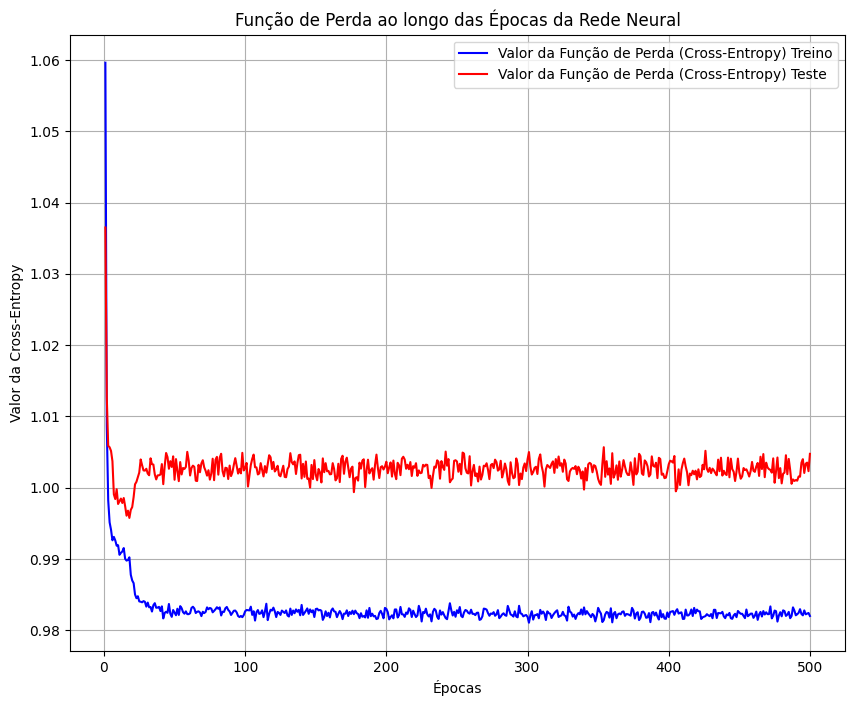

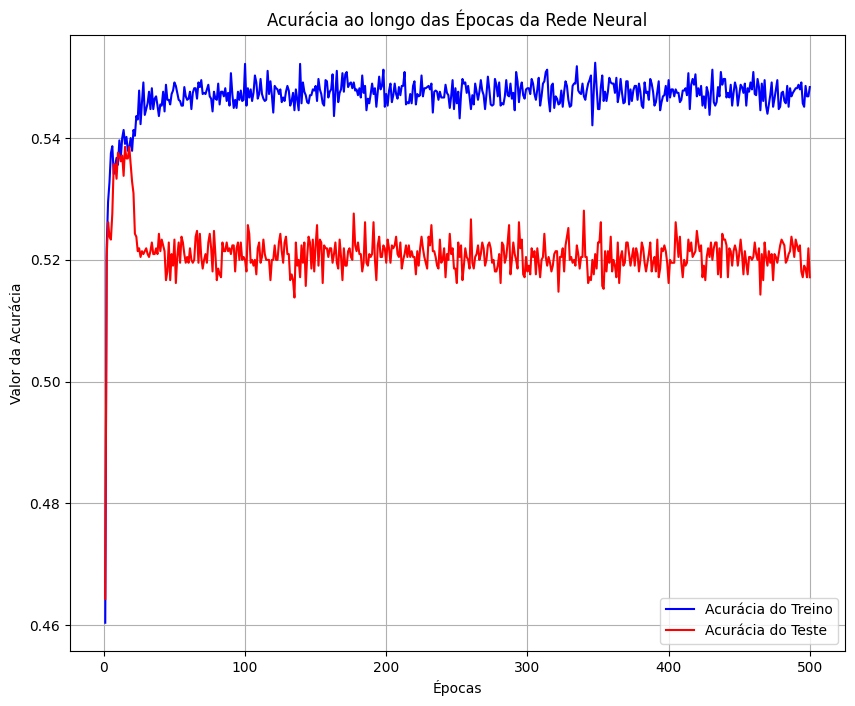

Erro(CROSS) do teste:  1.0047447681427002
Acurácia do teste:  0.5171428322792053


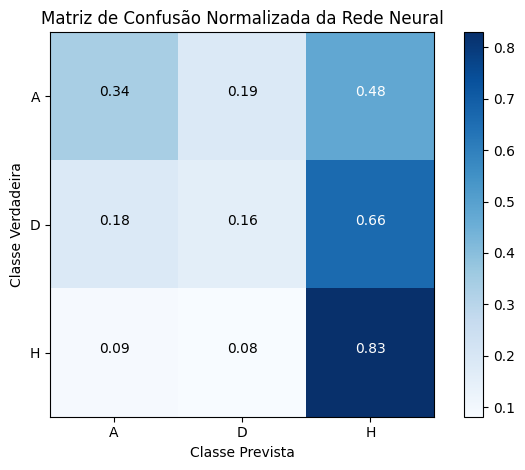

In [14]:
nn_loss, nn_acc = nn.trainTest(x_train_encoded, y_train_encoded, x_test_encoded, y_test_encoded,
                               best_parameters_nn, 350)

# A ideia inicial era fazer o teste com valores aleatórios e fazer 5 vezes, mas como estamos usando uma divisão temporal
# Isso não pode ser feito

F1 score and accuracy score for training set: 0.7434, 0.7686.
F1 score and accuracy score for test set: 0.6102, 0.6557.


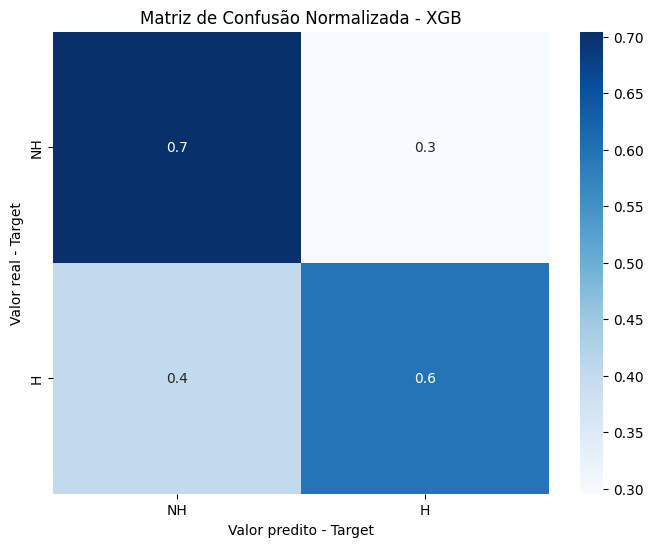

In [15]:
xgb_f1, xgb_acc = xgb.trainTest(x_train_encoded, y_train_, x_test_encoded, y_test_, best_parameters_xgb)


In [16]:
print(nn_loss, nn_acc)

print(xgb_f1, xgb_acc)

1.0047447681427002 tensor(0.5171)
0.6102425876010781 0.6557142857142857
